In [1]:
import sys
sys.path.append("D:\python\lib\site-packages")
import pyxdf as xdf
import numpy as np
import matplotlib.pyplot as plt
import mne
%matplotlib notebook

### QUICK START


In [2]:
yoshe_xdf = "yoshe_test.xdf"
annach_xdf = "annachess_test.xdf"
annag_xdf = "annag_test.xdf"

xdf_data = [yoshe_xdf, annach_xdf,annag_xdf]

for file in xdf_data:

    current_xdf = file

    streams = xdf.load_xdf(current_xdf)

    # Extract streams
    unitystr_time_series     = streams[0][0]['time_series']
    unitystr_time_stamps     = streams[0][0]['time_stamps']
    unitystr_first_timestamp = np.float(unitystr_time_stamps[0])#np.float(streams[0][0]['footer']['info']['first_timestamp'][2])

    eeg_time_series     = streams[0][2]['time_series']
    eeg_time_stamps     = streams[0][2]['time_stamps']
    eeg_first_timestamp = np.float(streams[0][2]['footer']['info']['first_timestamp'][0])

    # Sampling frequency of the recorded eeg data
    sfreq = np.float(streams[0][2]['info']['nominal_srate'][0])

    #Convert labels to codes: 1-chose high, 2-chose low, 3- Reward high, 4-reward low, 5-no reward

    for i in range (len(unitystr_time_series)):
        if "PressedHigh" in str(unitystr_time_series[i]):
            unitystr_time_series[i]=int(1)
        elif "PressedLow" in str(unitystr_time_series[i]):
            unitystr_time_series[i]=int(2)
        elif "RewardHigh" in str(unitystr_time_series[i]):
            unitystr_time_series[i]=int(3)
        elif "RewardLow" in str(unitystr_time_series[i]):
            unitystr_time_series[i]=int(4)
        elif "RewardNone" in str(unitystr_time_series[i]):
            unitystr_time_series[i]=int(5)

    #Code to cleanup and trim the mismatching unity timestamps

    for i in range (len(unitystr_time_stamps)):
        if unitystr_time_stamps[i] < eeg_time_stamps[0]:
            unitystr_time_stamps[i] = 0
            unitystr_time_series[i] = 0
        if unitystr_time_stamps[i] > eeg_time_stamps[-1]:
            unitystr_time_stamps[i] = 0
            unitystr_time_series[i] = 0


    #if you want to analyse only reward markers uncomment this:
    for i in range (len(unitystr_time_series)):
        if unitystr_time_series[i] == 1:
            unitystr_time_stamps[i] = 0
            unitystr_time_series[i] = 0
        if unitystr_time_series[i] == 2:
            unitystr_time_stamps[i] = 0
            unitystr_time_series[i] = 0


    def remove_values_from_list(the_list, val):
       return [value for value in the_list if value != val]

    C_unitystr_time_series = remove_values_from_list(unitystr_time_series, 0)
    C_unitystr_time_stamps = unitystr_time_stamps[unitystr_time_stamps!=0]


    # 14 channels: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4
    ch_names = ('AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4')

    # Create the info file
    info = mne.create_info(ch_names, sfreq, ch_types='eeg' )

    # Convert first time to sample
    first_samp = int(eeg_first_timestamp*sfreq)

    # NB set the first sample to be able to align the events
    raw = mne.io.RawArray(eeg_time_series.T, info, first_samp=first_samp)

    montage = mne.channels.read_montage('standard_1020')

    raw.set_montage(montage)

    # Create a new stimulation channels
    info         = mne.create_info(['STI'], raw.info['sfreq'], ch_types=['stim'])
    # Fill it with an vector of zeros
    stim_data    = np.zeros((1, len(raw.times)))

    stim_raw     = mne.io.RawArray(stim_data, info, first_samp=first_samp)

    # Add the new channel to your dataset
    raw.add_channels([stim_raw], force_update_info=False)

    (C_unitystr_time_stamps*sfreq).astype('int')

    # You need to build an array of events
    events = np.array(((C_unitystr_time_stamps*sfreq).astype('int'), np.zeros((len(C_unitystr_time_series),)), np.squeeze([C_unitystr_time_series])))

    # Add the openvibe events
    raw.add_events(events.T, stim_channel='STI')

    ### Re-reference your data
    raw.set_eeg_reference()

    ## evs should return the same 'events' array you used to create the channel ( I did it just to confirm that all the events are there)


    # With the option output='onset' we find only 26 events NB EVENTS ARE VERY CLOSE (JUST 1 TIMESTAMP BETWEEN TWO EVENTS)
    # If you set it to 'step' you will have back all the 52 events (but it does not make sense for epoching your data)



    evs = mne.find_events(raw, stim_channel='STI', output='onset', shortest_event=1,
                             min_duration=1/raw.info['sfreq'])
    print('Number of events found: %d' % len(evs))

    # Pick the channels you want to include 
    reject = dict(eeg=150e-6) # you can set a rejection threshold for bad data (NB in this case all data will be discarded)

    baseline = (None,None)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, ecg=False, eog=False, stim=False, exclude=[])


    # Define the beginning and the end of each epoch
    tmin = -1.
    tmax = 1

    # Epoch the data around event 1 (here defined as "trial_start")
    epochs =  mne.Epochs(raw, evs, tmin=tmin, tmax=tmax, 
                         baseline=baseline, preload=True, reject=None)

    # Check if all the epochs (nr of trials in the experiment) were extracted
    print('Number of epochs: %d' % len(epochs))

    if current_xdf == yoshe_xdf:
        epochs_yoshe = epochs
        raw_yoshe = raw
    if current_xdf == annach_xdf:
        epochs_annach = epochs
        raw_annach = raw
    if current_xdf == annag_xdf:
        epochs_annag = epochs
        raw_annag = raw

print("")    
print("----------------")    
print(epochs_yoshe, raw_yoshe)
print("----------------")
print(epochs_annach, raw_annach)
print("----------------")
print(epochs_annag, raw_annag)

Creating RawArray with float64 data, n_channels=14, n_times=57256
    Range : 19664 ... 76919 =    153.625 ...   600.930 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=57256
    Range : 19664 ... 76919 =    153.625 ...   600.930 secs
Ready.
Applying average reference.
Applying a custom EEG reference.
38 events found
Event IDs: [3 5]
Number of events found: 38
38 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 38 events and 257 original time points ...
0 bad epochs dropped
Number of epochs: 38
Creating RawArray with float64 data, n_channels=14, n_times=53964
    Range : 10176 ... 64139 =     79.500 ...   501.086 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=53964
    Range : 10176 ... 64139 =     79.500 ...   501.086 secs
Ready.
Applying average reference.
Applying a custom EEG reference.
48 events found
Event IDs: [3 4 5]
Number of events found: 48
48 matc

In [3]:
epochs_all = mne.concatenate_epochs([epochs_yoshe, epochs_annach, epochs_annag])
raw_all = mne.concatenate_raws([raw_yoshe, raw_annach, raw_annag])
print(epochs_all, raw_all)

136 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 bad epochs dropped
<Epochs  |   136 events (all good), -1 - 1 sec, baseline [None, None], ~4.0 MB, data loaded,
 '3': 51
 '4': 17
 '5': 68> <RawArray  |  None, n_channels x n_times : 15 x 162044 (1266.0 sec), ~18.6 MB, data loaded>


mne extract power; take windows of 100ms and average the values of these (windowlength and overlapping of the time windows is up to us)or 500ms and moving of 200, etc normally overlapping is 80%. it will be a vector of all the freq values of this timeframe and those can be fed to the network. he suggests recurrent network. make it parametric so we can modify variables. important to put labels

In [4]:
from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate

this_epoch = epochs_all
raw = raw_all

#['AF3', 'AF4', 'F3', 'F4', 'FC5', 'FC6']
this_epoch.drop_channels(['AF3', 'F7', 'F3', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'F4', 'F8', 'AF4'])

epochs_train = this_epoch.copy()
labels = this_epoch.events[:, -1]


# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = this_epoch.get_data()
epochs_data_train = epochs_train.get_data()


#cv = ShuffleSplit(10, test_size=0.2, random_state=42)
#cv_split = cv.split(epochs_data_train)
# Generate 10 folds for cross-validation using 20% of data as test set
cv = ShuffleSplit(10, test_size=.2, random_state=42)
cv_split = cv.split(epochs_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
#csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp = CSP(n_components=4, reg='ledoit_wolf', log=None, cov_est='epoch', norm_trace=False)

#for i in epochs_data_train:
    #print(i.shape)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# # plot CSP patterns estimated on full data for visualization
# csp.fit_transform(epochs_data, labels)

# layout = read_layout('EEG1005')
# csp.plot_patterns(this_epoch.info, layout=layout, ch_type='eeg',
#                   units='Patterns (AU)', size=1.0)

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.


/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)


Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 


Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using

/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Classification accuracy: 0.914286 / Chance level: 0.500000


/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res = transformer.fit_transform(X, y, **fit_params)
/Users/annasharkova/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:614: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  res 

In [5]:
# layout = read_layout('EEG1005')
# csp.plot_patterns(this_epoch.info, layout=layout, ch_type='eeg',
#                   units='Patterns (AU)', size=1.0)

print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))
;

Classification accuracy: 0.989286 / Chance level: 0.500000


''

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using 

<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.

Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.
Estimating covariance using LEDOIT_WOLF
Done.


<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
<ipython-input-5-497e1b94eae0>:11: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)


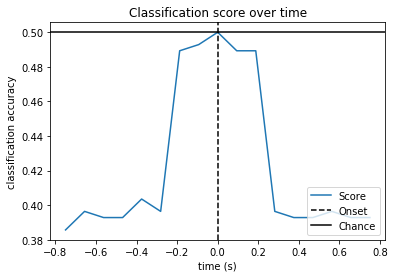

''

In [5]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + this_epoch.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()
;